使用设备: cuda
创建模型: deeplabv3 使用编码器 resnet50


Epoch 1/30 - Validation: 100%|██████████| 942/942 [02:09<00:00,  7.29it/s]


Epoch 1/30 - Train Loss: 0.0621, Val Loss: 0.0220
✅ 保存最佳模型，验证损失: 0.0220


Epoch 2/30 - Validation: 100%|██████████| 942/942 [02:08<00:00,  7.31it/s]


Epoch 2/30 - Train Loss: 0.0201, Val Loss: 0.0204
✅ 保存最佳模型，验证损失: 0.0204


Epoch 3/30 - Validation: 100%|██████████| 942/942 [02:13<00:00,  7.06it/s]


Epoch 3/30 - Train Loss: 0.0170, Val Loss: 0.0157
✅ 保存最佳模型，验证损失: 0.0157


Epoch 4/30 - Validation: 100%|██████████| 942/942 [02:09<00:00,  7.27it/s]


Epoch 4/30 - Train Loss: 0.0156, Val Loss: 0.0156
✅ 保存最佳模型，验证损失: 0.0156


Epoch 5/30 - Validation: 100%|██████████| 942/942 [02:12<00:00,  7.12it/s]


Epoch 5/30 - Train Loss: 0.0138, Val Loss: 0.0136
✅ 保存最佳模型，验证损失: 0.0136


Epoch 6/30 - Validation: 100%|██████████| 942/942 [02:14<00:00,  7.03it/s]


Epoch 6/30 - Train Loss: 0.0130, Val Loss: 0.0146


Epoch 7/30 - Validation: 100%|██████████| 942/942 [02:14<00:00,  7.03it/s]


Epoch 7/30 - Train Loss: 0.0119, Val Loss: 0.0131
✅ 保存最佳模型，验证损失: 0.0131


Epoch 8/30 - Validation: 100%|██████████| 942/942 [02:10<00:00,  7.20it/s]


Epoch 8/30 - Train Loss: 0.0114, Val Loss: 0.0166


Epoch 9/30 - Validation: 100%|██████████| 942/942 [02:14<00:00,  7.00it/s]


Epoch 9/30 - Train Loss: 0.0107, Val Loss: 0.0145


Epoch 10/30 - Validation: 100%|██████████| 942/942 [02:08<00:00,  7.34it/s]


Epoch 10/30 - Train Loss: 0.0100, Val Loss: 0.0170


Epoch 11/30 - Validation: 100%|██████████| 942/942 [02:09<00:00,  7.26it/s]


Epoch 11/30 - Train Loss: 0.0093, Val Loss: 0.0133


Epoch 12/30 - Validation: 100%|██████████| 942/942 [02:07<00:00,  7.39it/s]


Epoch 12/30 - Train Loss: 0.0087, Val Loss: 0.0147
早停触发，验证损失在 5 个周期内没有改善。


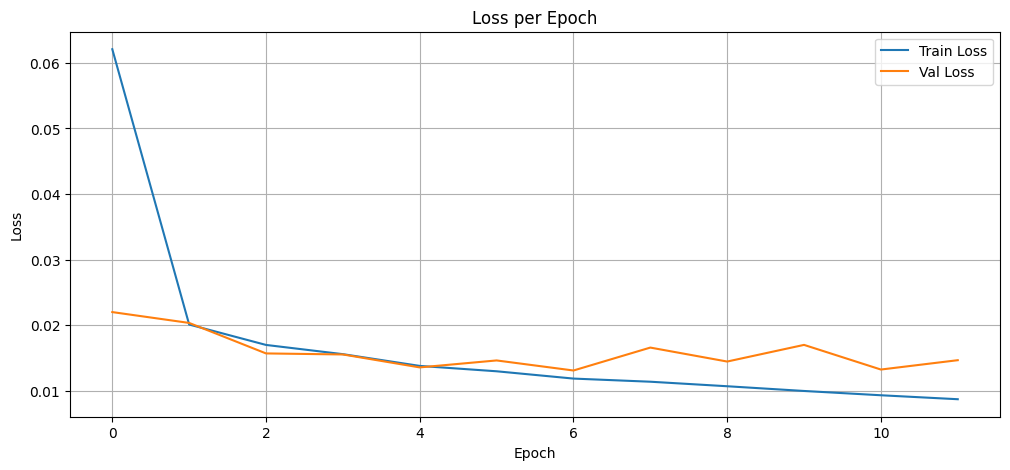

✅ 训练完成! 最佳验证损失: 0.0131
模型保存在: pretrained/smp_deeplabv3_resnet50_best.pth


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from model import SMPModel, get_smp_model
from dataset import SteelDataset
import torchvision.transforms as T
import pandas as pd
from tqdm import tqdm
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# 数据加载
df = pd.read_csv("../data/train.csv")
transform = T.Compose([
    T.ToTensor(),
])

dataset = None
dataset = SteelDataset(df, "../data/train_images", transform)

# 划分训练/验证集
train_len = int(0.7 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=4, drop_last=True)

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 选择模型类型和编码器
model_type = "deeplabv3"  # 可选: 'unet', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3plus', 'unet++'
encoder_name = "resnet50"  # 可选: 'resnet34', 'efficientnet-b0', 'mobilenet_v2', 'efficientnet-b3'
classes = 4  # 四种钢铁缺陷类别

# 创建模型
model = None
model = get_smp_model(model_type, encoder_name, classes).to(device)
print(f"创建模型: {model_type} 使用编码器 {encoder_name}")

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 使用 SMP 的损失函数
# DiceLoss 适合分割任务
dice_loss = smp.losses.DiceLoss(mode='multilabel')
# 也可以使用组合损失函数
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
focal_loss = smp.losses.FocalLoss(mode='multilabel', gamma=2.0, alpha=0.8)
# loss_fn = lambda pred, target: dice_loss(pred, target) + focal_loss(pred, target)
# loss_fn = lambda pred, target: dice_loss(pred, target) + bce_loss(pred, target)
loss_fn = lambda pred, target: focal_loss(pred, target) + bce_loss(pred, target)

# 训练参数
num_epochs = 30
early_stop_patience = 5
early_stop_count = 0
best_val_loss = float('inf')

# 创建保存检查点的文件夹
os.makedirs("pretrained", exist_ok=True)

train_losses = []
val_losses = []

# 训练循环
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

    for imgs, masks in train_bar:
        imgs, masks = imgs.to(device), masks.to(device)

        # 前向传播
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新进度条
        train_loss += loss.item()
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    First = True
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # 打印训练和验证损失
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 保存最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"pretrained/smp_{model_type}_{encoder_name}_best.pth")
        print(f"✅ 保存最佳模型，验证损失: {best_val_loss:.4f}")
        early_stop_count = 0
    else:
        early_stop_count += 1

    # 保存最新的检查点
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, f"pretrained/smp_{model_type}_{encoder_name}_latest.pth")

    if early_stop_count >= early_stop_patience:
        print(f"早停触发，验证损失在 {early_stop_patience} 个周期内没有改善。")
        break

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ 训练完成! 最佳验证损失: {best_val_loss:.4f}")
print(f"模型保存在: pretrained/smp_{model_type}_{encoder_name}_best.pth")